# Week 12 Value function-based Reinforcement Learning Algorithms

### Q1:
Imagine an MDP with two states ($S_1$ and $S_2$) and in which $S_1$ has two actions ($a_1$ and $a_2$) and $S_2$
has only one action ($a_1$). Suppose the discount factor is $\gamma$ and suppose you run Q-learning with a
Q-table initialized with all zero values and with learning rate $\alpha$.
- **a)** On the first transition, you start in state $S_1$, apply action $a_1$, receive an immediate reward of
1 and then land in state $S_2$. What is the resulting value of $Q(S_1, a_1)$? Give your answer as
an algebraic expression that may include one or both of the symbols $\gamma$ and $\alpha$.
- **b)**  On the second transition, you apply action $a_1$, receive an immediate reward of 0 and then
land in state $S_1$. What is the resulting value of $Q(S_2, a_1)$? Give your answer as
an algebraic expression that may include one or both of the symbols $\gamma$ and $\alpha$.
- **c)**  ) On the third transition, you apply action $a_2$, receive an immediate reward of 1 and then land
in state $S_2$. What is the resulting value of $Q(S_1, a_2)$? Give your answer as
an algebraic expression that may include one or both of the symbols $\gamma$ and $\alpha$.

### Q-Learning

Q-Learning is based on the notion of a Q-function. The Q-function (a.k.a the state-action value function) of a policy $\pi$, $Q^{\pi}(s, a)$, measures the expected return or discounted sum of rewards obtained from state $s$ by taking action $a$ first and following policy $\pi$ thereafter. We define the optimal Q-function $Q^*(s, a)$ as the maximum return that can be obtained starting from observation $s$, taking action $a$ and following the optimal policy thereafter. The optimal Q-function obeys the following *Bellman* optimality equation: 

$\begin{equation}Q^\ast(s, a) = \mathbb{E}[ r + \gamma \max_{a'} Q^\ast(s', a') ]\end{equation}$

This means that the maximum return from state $s$ and action $a$ is the sum of the immediate reward $r$ and the return (discounted by $\gamma$) obtained by following the optimal policy thereafter until the end of the episode (i.e., the maximum reward from the next state $s'$). The expectation is computed both over the distribution of immediate rewards $r$ and possible next states $s'$.

The basic idea behind Q-Learning is to use the Bellman optimality equation as an iterative update $Q_{i+1}(s, a) \leftarrow \mathbb{E}\left[ r + \gamma \max_{a'} Q_{i}(s', a')\right]$, and it can be shown that this converges to the optimal $Q$-function, i.e. $Q_i \rightarrow Q^*$ as $i \rightarrow \infty$ (see the [DQN paper](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)).

### Summing up the Q-Learning Process
In a way, Reinforcement Learning is the science of making optimal decisions using experiences. Breaking it down, the process of Reinforcement Learning involves these simple steps:

1. Initialize the Q-table by all zeros.
2. Start exploring actions: For each state, select any one among all possible actions for the current state (S).
3. Travel to the next state (S') as a result of that action (a).
4. For all possible actions from the state (S') select the one with the highest Q-value.
5. Update Q-table values using the equation.
6. Set the next state as the current state.
7. If goal state is reached, then end and repeat the process.

Observation of the environment > Deciding how to act using some strategy > Acting accordingly > Receiving a reward or penalty > Learning from the experiences and refining our strategy/policy > Iterate until an optimal strategy is found

### Practical Tips for Q-learning
- Q-learning takes some care to stablize. Test on easy, reliable tasks first, make sure your implementation is correct.
- Large replay buffers help improve stability.
- It takes time, be patient – might be no better than random for a while.
- Start with high exploration (epsilon) and gradually reduce.
- Bellman error (regression error) gradients can be big; clip gradients or use Huber loss.
- Double Q-learning helps a lot in practice, simple and no downsides.
- Schedule exploration (high to low) and learning rates (high to low), Adam optimizer can help too.
- Run multiple random seeds, it’s very inconsistent between runs.

## T1: [n-Chain](https://gym.openai.com/envs/NChain-v0/): 
The n-Chain environment is taken from the OpenAI Gym module (official documentation),which is a simple 5 state environment.

This game presents moves along a linear chain of states, with two actions:
* action 0 = move forward along the chain, but get no reward 
* action 1 = move backward to state 0, get small reward of 2

The diagram below demonstrates this environment:

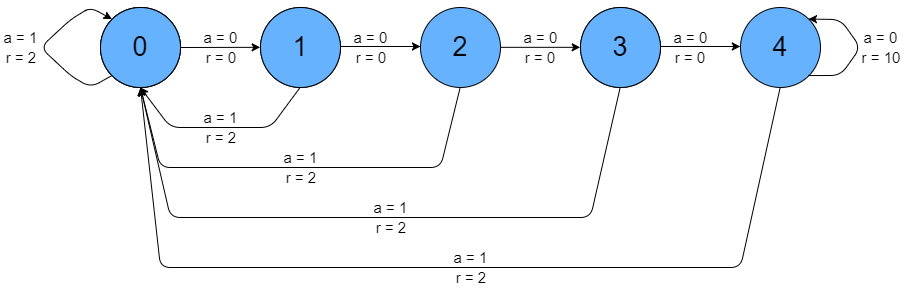

When action 1 is taken, i.e. move backwards, there is an immediate reward of 2 given to the agent – and the agent is returned to state 0 (back to the beginning of the chain). However, when a move forward action is taken (action 0), there is no immediate reward until state 4. When the agent moves forward while in state 4, a reward of 10 is received by the agent. The agent stays in state 4 at this point also, so the reward can be repeated. There is also a random chance that the agent’s action is “flipped” by the environment (i.e. an action 0 is flipped to an action 1 and vice versa).

In [1]:
# load other necessary pytho modules
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import warnings
import time

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

ModuleNotFoundError: No module named 'gym'

In [3]:
# initialize the nchain environment
env = gym.make('NChain-v0')

In [4]:
# get 10 randomly sampled actions
[env.action_space.sample() for ii in range(10)]

[0, 1, 1, 1, 0, 1, 1, 1, 0, 0]

In [5]:
# define the class which consists the Q-learning algorithm
class QAgent(object):
    """
    Implementation of a Q-learning Algorithm
    """
    def __init__(self, env, name, state_size, action_size, learning_parameters, exploration_parameters): 
        """
        initialize the Q-learning agent
        Args:
          name (str): set the name of the Q-Agent
          state_size (int): ..
          action_size (int): ..
          learning_parameters (dict): 
          exploration_parameters (dict):
        """
        self.name = name
                
        # init the Q-table
        self.qtable = np.zeros((state_size, action_size))
        self.result = np.zeros((state_size, action_size))
        
        # learning parameters
        self.learning_rate = learning_parameters['learning_rate']
        self.gamma = learning_parameters['gamma']
        
        # exploration parameters
        self.epsilon = exploration_parameters['epsilon']      
        self.max_epsilon = exploration_parameters['max_epsilon']
        self.min_epsilon = exploration_parameters['min_epsilon']
        self.decay_rate = exploration_parameters['decay_rate']    
        
        self.env = env
    
    
    def q_learning(self, plot = False, max_steps = 10, total_episodes = 1000):
        """
        implementation of the q-learning algorithm, here the q-table values are calculated
        Args:
          plot (boolean): set true, to get trainings progress 
          max_steps (int): number of stepts an agent can take, before the environment is reset 
          total_episodes (int): total of training episodes (the number of trials a agent can do)          
        """

        # create placeholders to store the results
        self.episode_rewards = np.zeros(total_episodes) 
        self.episode_epsilon = np.zeros(total_episodes)
        self.episode_last_state = np.zeros(total_episodes)
        
        start = time.time()
        # loop over all episodes
        for episode_i in range(total_episodes):
            # initalize the environment
            state = self.env.reset()
            
            # for each episode loop over the max number of steps that are possible
            for step in range(max_steps):   
                
                # get action, e-greedy
                action = self.get_action(state)
                               
                # take an action and observe the outcome state (new_state), reward and stopping criterion
                new_state, reward, done, _ = self.env.step(action)

                self.qtable[state, action] = self.update_qtable(state, new_state, action, reward, done)
                state = new_state
                self.episode_rewards[episode_i] += reward            
                self.result = np.dstack((self.result, self.qtable))

                # check stopping criterion
                if done == True:
                    break
            
            self.episode_rewards[episode_i] /= step # average the reward
            self.episode_last_state[episode_i] = state # average the reward
            
            # reduce epsilon, for exploration-exploitation tradeoff
            self.update_epsilon(episode_i)
            
            if episode_i % 100 == 0 and plot:
                print('episode: {}'.format(episode_i))
                print('\telapsed time [min]: {}'.format(round( (time.time() - start)/60, 1)))

            
    def update_qtable(self, state, new_state, action, reward, done):
        """
        update the q-table: Q(s,a) = Q(s,a) + lr  * [R(s,a) + gamma * max Q(s',a') - Q (s,a)]
        Args:
          state (int): current state of the environment
          new_state (int): new state of the environment
          action (int): current action taken by agent
          reward (int): current reward received from env
          done (boolean): variable indicating if env is done
        Returns:
          qtable (array): the qtable containing a value for every state (y-axis) and action (x-axis) 
        """
        return self.qtable[state,action] + self.learning_rate * \
                          (reward + self.gamma * np.max(self.qtable[new_state, :]) * (1- done) - self.qtable[state, action])
    
    
    def update_epsilon(self, episode):
        """
        reduce epsilon, exponential decay
        Args:
          episode (int): number of episode
        """
        self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(-self.decay_rate*episode)

        
    def get_action(self, state):
        """
        select action e-greedy
        Args:
          state (int): current state of the environment/agent
        Returns:
          action (int): action that the agent will take in the next step
        """
        if random.uniform(0,1) >= self.epsilon:
            # exploitation, max value for given state
            action = np.argmax(self.qtable[state, :])
        else:
            # exploration, random choice
            action = self.env.action_space.sample()
        return action

If we think about the previous iteration of the agent training model using Q learning, the action selection policy is based solely on the maximum Q value in any given state. It is conceivable that, given the random nature of the environment, that the agent initially makes “bad” decisions. The Q values arising from these decisions may easily be “locked in” – and from that time forward, bad decisions may continue to be made by the agent because it can only ever select the maximum Q value in any given state, even if these values are not necessarily optimal. This action selection policy is called a greedy policy.

So we need a way for the agent to eventually always choose the “best” set of actions in the environment, yet at the same time allowing the agent to not get “locked in” and giving it some space to explore alternatives. What is required is the $\epsilon$-greedy policy.

The $\epsilon$-greedy policy in reinforcement learning is basically the same as the greedy policy, except that there is a value $\epsilon$ (which may be set to decay over time) where, if a random number is selected which is less than this value, an action is chosen completely at random. This step allows some random exploration of the value of various actions in various states, and can be scaled back over time to allow the algorithm to concentrate more on exploiting the best strategies that it has found

In [6]:
# avoid slipping in on the chain
env.env.slip = 0

action_size = env.action_space.n
state_size = env.observation_space.n

# Set the Training parameters
# set true, to get printed out the trainings progress
plot = False 
#plot = True
# Set number of stepts an agent can take, before the environment is reset, 
max_steps = 10 
# Set total of training episodes (the number of trials a agent can do)    
total_episodes = 1000

After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called ϵ "epsilon" to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

### Agent 1
Create an agent that explores and takes future rewards into account

In [7]:
### case1
name = 'case1, the agent explores and takes future rewards into account'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 1,
    'min_epsilon': 0.0,
    'decay_rate': 0.008} # smaller decay rate, more exploration

q_agent_1 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_1.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)

### Agent 2
Create an agent that cares only about immediate rewards (gamma is very small)

In [8]:
### case2
name = 'case2, the agent cares only about immediate rewards (small gamma)'

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.01} # gamma = 1, we care about all future rewards equally as the current one  
            # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.5,
    'min_epsilon': 0.0,
    'decay_rate': 0.008} # smaller decay rate, more exploration


q_agent_2 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_2.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)


### Agent 3
Create an agent that doesn't explore the environment (small epsilon)

In [9]:
### case3
name = "case3, the agent doesn't explore the environment (small epsilon)"

# q-learning parameters
learning_parameters = {
    'learning_rate': 0.8,
    'gamma': 0.9} # gamma = 1, we care about all future rewards equally as the current one  
                  # gamma = 0, we only care about the current reward)

# exploration-exploitation parameters
exploration_parameters = {
    'epsilon': 1,
    'max_epsilon': 0.2,
    'min_epsilon': 0.0,
    'decay_rate': 0.5} # smaller decay rate, more exploration


q_agent_3 = QAgent(env, name, state_size, action_size, learning_parameters, exploration_parameters)
q_agent_3.q_learning(plot = plot, max_steps = max_steps, total_episodes = total_episodes)

In [10]:
def visualize_episodes(*cases):
    """
    create a visualization method
    Args:
        cases (object): trained q-learning agent
    """

    plt.figure(figsize=(10,15))
    colour = ['orange', 'm','b','k','g']
    
    # 1
    plt.subplot(3,1,1)
    plt.title('Reward over time per episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_rewards, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)
    
    # 2
    plt.subplot(3,1,2)
    plt.title('Exploration parameter epsilon per episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_epsilon, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('Epsilon')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)  
    
    # 3
    plt.subplot(3,1,3)
    plt.title('Last state the agent is standing on at the end of the episode')
    for i, case in enumerate(cases):
        plt.plot(case.episode_last_state, c = colour[i], label = case.name, 
                 linewidth = 1, linestyle = '-', alpha = 0.7)
    plt.xlabel('# episodes')
    plt.ylabel('state number')
    plt.grid()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=1)  
    plt.tight_layout()
    plt.show()
    

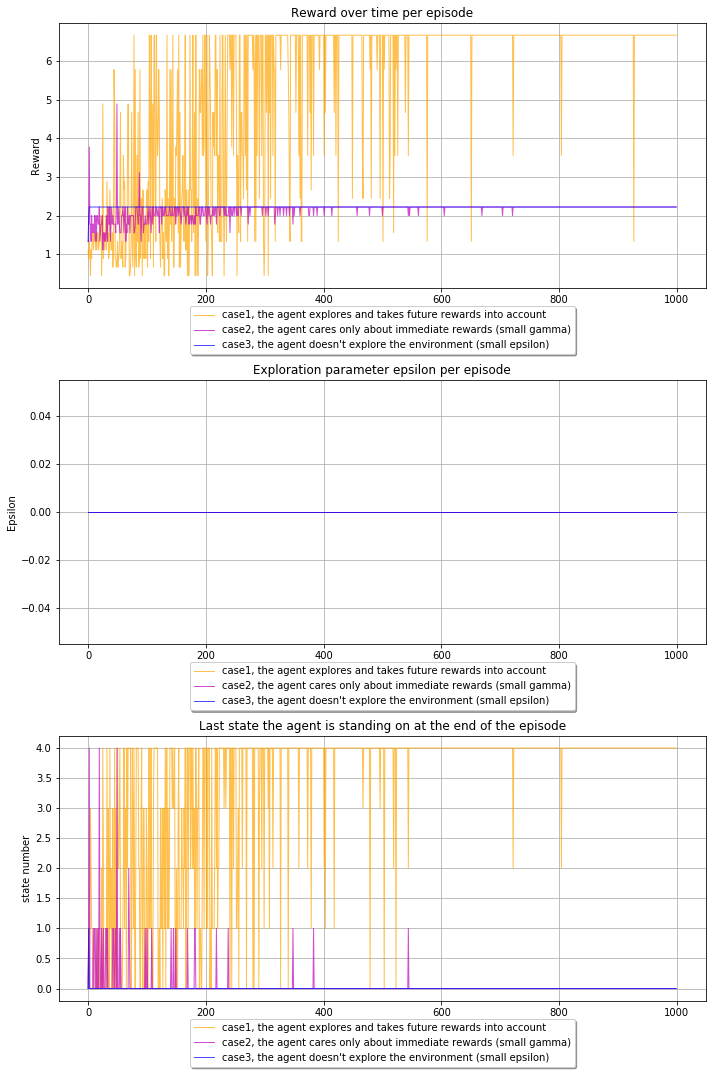

In [11]:
# visualize the different set of parameters
visualize_episodes(q_agent_1, q_agent_2, q_agent_3)

* y-axis: state 0 to state 4
* x-axis: action 0 and action 1
* action 0 = move forward, but get no reward (in the last state get large reward)
* action 1 = move backward to state 0, get small reward
### higher values mean higher future rewards for this specific action-state pair

In [12]:
print('case1:\n {},\n\ncase2:\n {},\n\ncase3:\n {}'.format(np.around(q_agent_1.qtable,1),
                                                     np.around(q_agent_2.qtable,1),
                                                     np.around(q_agent_3.qtable,1))) 


case1:
 [[ 65.6  61. ]
 [ 72.9  61. ]
 [ 81.   61. ]
 [ 90.   61. ]
 [100.   61. ]],

case2:
 [[ 0.   2. ]
 [ 0.   2. ]
 [ 0.   2. ]
 [ 0.1  0. ]
 [10.1  2. ]],

case3:
 [[ 4.1 20. ]
 [ 0.   4.7]
 [ 0.   3.8]
 [ 0.   0. ]
 [ 0.   0. ]]


The q-table of case1 should have similar values like the following table:

|    ----   | Action 0  | Action 1 | 
| ------------- | ------------- | ------------- |
| state 0 | 65.61  | 61.049  |
| state 1 | 72.9  | 61.049  |
| state 2 | 81.  | 61.049  |
| state 3 | 90.  | 61.049  |
| state 4 | 100.  | 61.049  |

## T2: Self-Driving Cab via RL
Let's design a simulation of a self-driving cab. The major goal is to demonstrate, in a simplified environment, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

The Smartcab's job is to pick up the passenger at one location and drop them off in another. Here are a few things that we'd love our Smartcab to take care of:
1. Drop off the passenger to the right location.
2. Save passenger's time by taking minimum time possible to drop off
3. Take care of passenger's safety and traffic rules
4. There are different aspects that need to be considered here while modeling an RL solution to this problem: rewards, states, and actions.

### Rewards
1. The agent should receive a high positive reward for a successful dropoff because this behavior is highly desired
2. The agent should be penalized if it tries to drop off a passenger in wrong locations
3. The agent should get a slight negative reward for not making it to the destination after every time-step. "Slight" negative because we would prefer our agent to reach late instead of making wrong moves trying to reach to the destination as fast as possible

### State Space
In Reinforcement Learning, the agent encounters a state, and then takes action according to the state it's in.

The State Space is the set of all possible situations our taxi could inhabit. The state should contain useful information the agent needs to make the right action.

Let's say we have a training area for our Smartcab where we are teaching it to transport people in a parking lot to four different locations (R, G, Y, B):
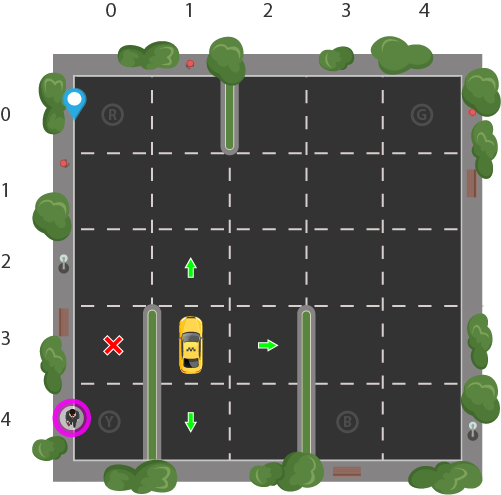
Let's assume Smartcab is the only vehicle in this parking lot. We can break up the parking lot into a 5x5 grid, which gives us 25 possible taxi locations. These 25 locations are one part of our state space. Notice the current location state of our taxi is coordinate (3, 1).

You'll also notice there are four (4) locations that we can pick up and drop off a passenger: R, G, Y, B or [(0,0), (0,4), (4,0), (4,3)] in (row, col) coordinates. Our illustrated passenger is in location Y and they wish to go to location R.

When we also account for one (1) additional passenger state of being inside the taxi, we can take all combinations of passenger locations and destination locations to come to a total number of states for our taxi environment; there's four (4) destinations and five (4 + 1) passenger locations.

So, our taxi environment has 5×5×5×4=500 total possible states.

### Action Space
The agent encounters one of the 500 states and it takes an action. The action in our case can be to move in a direction or decide to pickup/dropoff a passenger.

In other words, we have six possible actions:

1. south
2. north
3. east
4. west
5. pickup
6. dropoff
This is the action space: the set of all the actions that our agent can take in a given state.

You'll notice in the illustration above, that the taxi cannot perform certain actions in certain states due to walls. In environment's code, we will simply provide penalty for every wall hit and the taxi won't move anywhere. This will just rack up penalties causing the taxi to consider going around the wall.

### Q-Table
The Q-table is a matrix where we have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training. Note that the Q-table has the same dimensions as the reward table, but it has a completely different purpose.

Q-Table values are initialized to zero and then updated during training to values that optimize the agent's traversal through the environment for maximum rewards

In [13]:
#load the necessary pytho modules
import numpy as np
import gym
import random

In [32]:
#load the game environment and render what it looks like:
env = gym.make("Taxi-v3")
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



1. The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
2. The pipe ("|") represents a wall which the taxi cannot cross.
3. R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

In [33]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [34]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [35]:
env.P[328]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

This dictionary has the structure {action: [(probability, nextstate, reward, done)]}

In [36]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 200
Penalties incurred: 62


In [37]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")       
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)

Timestep: 200
State: 49
Action: 3
Reward: -1


Then, we'll initialize the Q-table to a 500×6 matrix of zeros:

In [38]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])
print(q_table)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


We can now create the training algorithm that will update this Q-table as the agent explores the environment over thousands of episodes.

In [39]:
%%time
"""Training the agent"""

#import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

Wall time: 44.7 s


Let's evaluate the performance of our agent. We don't need to explore actions any further, so now the next action is always selected using the best Q-value:

In [40]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100
frames = [] # for animation
for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 12.78
Average penalties per episode: 0.0


In [41]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 1278
State: 410
Action: 5
Reward: 20
